In [1]:
import os,sys
import platform
import numpy as np
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from segnet import segnet
from generator import DataGenerator, DataLoader

In [2]:
print(tf.__version__) # 2.1.0

2.1.0


In [3]:
#import keras
print(tf.keras.__version__) # 2.2.4-tf

2.2.4-tf


In [4]:
# keep these constant for now
nv=int(2**98) # variants
na=2          # alleles
nc=7          # ancestry classes (incl. OCE)

In [5]:
# hyperparameters
ne=100        # number of epochs
nf=8          # number of segnet filters
fs=16         # filter size
bs=8          # batch size
ps=4          # pool size
dp=4          # number of segnet blocks (depth)
wt=False      # use inverse frequency weighted loss -- this doesn't seem to help
gen=True      # use data generator
rem=[]        # remove these ancestries: [0:AFR, 1:EAS, 2:EUR, 3:NAT, 4:OCE, 5:SAS, 6:WAS]
dev=True      # do we have a dev set (this is jank if we're removing any ancestries, above)
ac=1          # minimum allele count for inclusion
stoch=True    # randomly sample individuals during training (requires gen=True)
               # sampling is currently inverse-frequency weighted

# reproducibility
np.random.seed(23910464)

In [6]:
# sanity check that we're on gpu -- use #1 (if we're on galangal)
if platform.uname()[1]=='galangal.stanford.edu':
    os.environ["CUDA_VISIBLE_DEVICES"]="1" 
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
from train import load_train_set, load_dev_set, filter_ac

In [8]:
X, Y, S, V, train_ix, ix1, ix2 = load_train_set()
X_dev, Y_dev, S_dev = load_dev_set()

[(2764, 516801, 2), (2764, 516801, 7), (2764,), 2090]
[(120, 516801, 2), (120, 516801, 7)]


In [9]:
if False: # print sizes of allocated objects -- 
    # can be a nice sanity check, but also annoying to look at
    for x in dir():
        print(x, sys.getsizeof(eval(x)))

In [10]:
# filter oceanians, etc.
if rem:
    train_ix=[i for i in train_ix if Y[i,0,:].dot(np.arange(nc)) not in rem]
    if dev:
        Y_dev=Y_dev[:,:,[i for i in range(nc) if i not in rem]] # this is hella janky
anc=[i for i in range(nc) if i not in rem]

In [11]:
# filter variants by allele count
v=filter_ac(X[train_ix,:,:], ac=ac)
print(np.sum(v))
nv=np.sum(v)-(np.sum(v) % (ps**dp))
v=np.array([i and j <= nv for i,j in zip(v, np.cumsum(v))])
print(np.sum(v))
#np.random.shuffle(train_ix)
#np.save('/scratch/users/magu/aY.npy', Y[np.ix_(train_ix, v, anc)])
#np.save('/scratch/users/magu/aX.npy', X[np.ix_(train_ix, v, np.arange(na))])
#X=np.load('/scratch/users/magu/aX.npy', mmap_mode='r')
#Y=np.load('/scratch/users/magu/aY.npy', mmap_mode='r')
Y=Y[np.ix_(train_ix, v, anc)]
X=X[np.ix_(train_ix, v, np.arange(na))]
X_dev=X_dev[:,v,:]
Y_dev=Y_dev[:,v,:]
print(X.shape, X_dev.shape, Y.shape, Y_dev.shape)

447827
447744
(2090, 447744, 2) (120, 447744, 2) (2090, 447744, 7) (120, 447744, 7)


In [12]:
# declare model
model=segnet(input_shape=(X.shape[1], na), n_classes=nc-len(rem), n_filters=nf, width=fs, n_blocks=dp, pool_size=ps)

# and optimizer
adam=optimizers.Adam(lr=3e-4)#, beta_1=0.8)

In [13]:
# now compile and show parameter summary
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy']) 
print(model.summary())

Model: "segnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 447744, 2)]  0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 447744, 2)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_down1 (Conv1D)            (None, 447744, 8)    264         dropout[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 447744, 8)    0           conv1_down1[0][0]                
_____________________________________________________________________________________________

In [14]:
# now try it out!

# number weighted epochs -- will be [ne] if wt=False else [0, ne] (ne is set above)
nwe=ne 
nes=[ne-(wt*nwe)]         
cws=[np.ones((nc,))]
if wt:
    nes.append(nwe)
    cws.append(np.sqrt(Y.sum()/Y.sum(axis=0).sum(axis=0)))
    
# training
np.random.shuffle(train_ix)
for ne,cw in zip(nes,cws):
    if ne == 0: # don't waste time compiling the model if we aren't training it -- see above
        continue
    if dev:
        # we have a dev set; use it to monitor convergence
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

        # fit with generator, or not
        if gen:
            params={'X':X, 'Y':Y, 'dim':nv, 'batch_size':bs, 'n_classes':nc, 'n_alleles':na}
            anc_fq=Y[:,0,:].sum(axis=0)
            generator=DataGenerator(np.arange(X.shape[0]), 
                                    sample=True, anc_wts=((1/anc_fq)/((1/anc_fq).sum())).flatten(),
                                    **params)
            history=model.fit_generator(generator=generator, epochs=ne, validation_data=(X_dev, Y_dev), 
                                        callbacks=[es], class_weight=cw)
        else:
            history=model.fit(X, Y, batch_size=bs, epochs=ne, 
                              validation_data=(X_dev, Y_dev), 
                              callbacks=[es], class_weight=cw)
    else:
        history=model.fit(X, Y, batch_size=bs, epochs=ne, class_weight=cw)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 261 steps, validate on 120 samples
Epoch 1/100
261/261 [==============================] - 6574s 25s/step - loss: 1.7763 - accuracy: 0.2554 - val_loss: 1.7627 - val_accuracy: 0.2830
Epoch 2/100
261/261 [==============================] - 704s 3s/step - loss: 1.7175 - accuracy: 0.2597 - val_loss: 1.7233 - val_accuracy: 0.3353
Epoch 3/100
261/261 [==============================] - 698s 3s/step - loss: 1.6758 - accuracy: 0.3727 - val_loss: 1.6974 - val_accuracy: 0.3464
Epoch 4/100
261/261 [==============================] - 692s 3s/step - loss: 1.6062 - accuracy: 0.4072 - val_loss: 1.6655 - val_accuracy: 0.3464
Epoch 5/100
261/261 [==============================] - 685s 3s/step - loss: 1.5828 - accuracy: 0.4242 - val_loss: 1.6511 - val_accuracy: 0.3464
Epoch 6/100
261/261 [==============================] - 693s 3s/step - loss: 1.5697 - accuracy: 0.4155 - val_loss: 1.6696 - val_accur

Epoch 55/100
261/261 [==============================] - 700s 3s/step - loss: 0.8930 - accuracy: 0.6872 - val_loss: 0.9889 - val_accuracy: 0.6617
Epoch 56/100
261/261 [==============================] - 678s 3s/step - loss: 0.8752 - accuracy: 0.6877 - val_loss: 1.1225 - val_accuracy: 0.6355
Epoch 57/100
261/261 [==============================] - 654s 3s/step - loss: 0.9262 - accuracy: 0.6733 - val_loss: 1.0477 - val_accuracy: 0.6465
Epoch 58/100
261/261 [==============================] - 653s 3s/step - loss: 0.9188 - accuracy: 0.6722 - val_loss: 1.0107 - val_accuracy: 0.6539
Epoch 59/100
261/261 [==============================] - 651s 2s/step - loss: 0.9375 - accuracy: 0.6637 - val_loss: 0.9591 - val_accuracy: 0.6703
Epoch 60/100
261/261 [==============================] - 651s 2s/step - loss: 0.9048 - accuracy: 0.6811 - val_loss: 0.9950 - val_accuracy: 0.6635
Epoch 61/100
261/261 [==============================] - 652s 2s/step - loss: 0.8925 - accuracy: 0.6828 - val_loss: 0.9908 - val_ac

In [ ]:
# save
model.save('chm20_short.dev.h5')

0.69111025


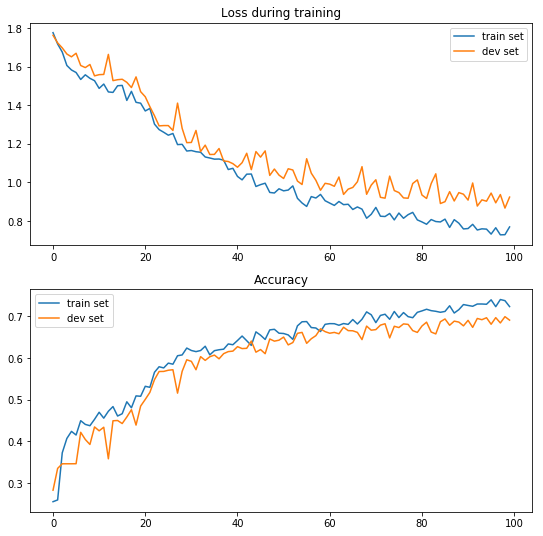

In [15]:
_, dev_acc = model.evaluate(X_dev, Y_dev, verbose=0)

# 1.1) plot loss during training
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(1, (9,9))
plt.subplot(211)
plt.title('Loss during training')
plt.plot(history.history['loss'], label='train set')
plt.plot(history.history['val_loss'], label='dev set')
plt.legend()

# 1.2) plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train set')
plt.plot(history.history['val_accuracy'], label='dev set')
plt.legend()

print(dev_acc)

In [16]:
Y_hat_p=model.predict(X_dev)
Y_hat=np.argmax(Y_hat_p, axis=-1) # this is p naive tbh

In [17]:
Y_hat.shape

(120, 447744)

In [18]:
Y.sum(axis=0).sum(axis=0)/Y.sum().sum().sum()

array([0.27655502, 0.3722488 , 0.11291866, 0.04880383, 0.01148325,
       0.1291866 , 0.04880383])

In [19]:
Y_dev.sum(axis=0).sum(axis=0)/Y_dev.sum().sum().sum()

array([0.28304479, 0.34642219, 0.13933135, 0.0666845 , 0.02318417,
       0.09198698, 0.04934602])

In [20]:
from sklearn.metrics import confusion_matrix
import pandas as pd

In [31]:
# rows are truth, columns are predictions -- normalized by total bp counts
anc=[i for i in range(nc) if i not in rem]
labels=[label for i,label in enumerate(['AFR','EAS','EUR','NAT','OCE','SAS','WAS']) if i in anc]
conf=confusion_matrix(Y_dev.dot(np.arange(nc-len(rem))).flatten(), Y_hat.flatten())

pd.DataFrame(conf/(Y_hat.shape[0]*nv), columns=labels, index=labels)

,AFR,EAS,EUR,NAT,OCE,SAS,WAS
AFR,0.259891,0.007999,0.009991,0.000013,0.0,0.005151,2.419537e-07
EAS,0.001152,0.330901,0.004084,0.001508,0.0,0.008776,1.861183e-08
EUR,0.008510,0.039257,0.060705,0.001841,0.0,0.029018,2.791774e-07
NAT,0.000090,0.038303,0.003615,0.021009,0.0,0.003668,0.000000e+00
OCE,0.001643,0.015634,0.002385,0.000208,0.0,0.003314,0.000000e+00
SAS,0.003397,0.048676,0.020756,0.000553,0.0,0.018604,7.444730e-08
WAS,0.005875,0.015319,0.016705,0.000432,0.0,0.011014,3.722365e-08


In [37]:
# rows are truth, columns are predictions -- normalized by ground truth (rows)
pd.DataFrame(conf, columns=labels, index=labels).divide(Y_dev.sum(axis=0).sum(axis=0), axis='rows')

,AFR,EAS,EUR,NAT,OCE,SAS,WAS
AFR,0.918197,0.028261,0.035299,0.000045,0.0,0.018197,8.548249e-07
EAS,0.003326,0.955197,0.011789,0.004353,0.0,0.025335,5.372585e-08
EUR,0.061075,0.281753,0.435688,0.013216,0.0,0.208266,2.003694e-06
NAT,0.001351,0.574387,0.054216,0.315046,0.0,0.055000,0.000000e+00
OCE,0.070848,0.674342,0.102880,0.008978,0.0,0.142952,0.000000e+00
SAS,0.036927,0.529162,0.225643,0.006016,0.0,0.202250,8.093244e-07
WAS,0.119066,0.310431,0.338536,0.008759,0.0,0.223208,7.543395e-07


In [43]:
# rows are truth, columns are predictions -- normalized by predictions (columns)
pd.DataFrame(conf, columns=labels, index=labels).divide(to_categorical(Y_hat).sum(axis=0).sum(axis=0))

,AFR,EAS,EUR,NAT,OCE,SAS,WAS
AFR,0.926337,0.016125,0.084497,0.000499,NaN,0.064751,0.371429
EAS,0.004107,0.667042,0.034540,0.058986,NaN,0.110332,0.028571
EUR,0.030331,0.079136,0.513394,0.072028,NaN,0.364796,0.428571
NAT,0.000321,0.077212,0.030576,0.821792,NaN,0.046107,0.000000
OCE,0.005855,0.031516,0.020172,0.008142,NaN,0.041664,0.000000
SAS,0.012107,0.098123,0.175540,0.021647,NaN,0.233883,0.114286
WAS,0.020942,0.030880,0.141281,0.016906,NaN,0.138466,0.057143


In [44]:
for i in range(Y_hat.shape[0]):
    print((i, [np.count_nonzero(Y_hat[i,:]==j) for j in range(Y_hat_p.shape[-1])], 
           [np.count_nonzero(Y_dev[i,:,:].argmax(axis=-1)==j) for j in range(Y_hat_p.shape[-1])]))

(0, [142769, 241370, 19266, 30701, 0, 13638, 0], [149802, 169365, 30460, 92153, 0, 0, 5964])
(1, [182459, 210225, 31011, 337, 0, 23712, 0], [184411, 184936, 36218, 0, 0, 42179, 0])
(2, [217234, 151031, 31257, 8332, 0, 39890, 0], [212307, 75177, 23734, 11342, 117591, 7593, 0])
(3, [56989, 329070, 23418, 10225, 0, 28042, 0], [56377, 306349, 42126, 42892, 0, 0, 0])
(4, [272252, 131772, 23458, 5430, 0, 14832, 0], [273641, 102483, 0, 40173, 0, 0, 31447])
(5, [91719, 250028, 57824, 948, 0, 47224, 1], [108380, 208767, 95185, 0, 0, 35412, 0])
(6, [146350, 177555, 68338, 3941, 0, 51559, 1], [138490, 56578, 0, 30753, 0, 221923, 0])
(7, [13537, 312718, 60246, 28420, 0, 32823, 0], [0, 238171, 113363, 96210, 0, 0, 0])
(8, [173072, 157623, 64530, 10905, 0, 41612, 2], [156399, 101424, 46036, 32409, 0, 0, 111476])
(9, [12333, 354829, 40194, 11314, 0, 29074, 0], [0, 342414, 82275, 23055, 0, 0, 0])
(10, [55918, 262102, 71981, 24820, 0, 32922, 1], [45973, 173843, 135636, 92292, 0, 0, 0])
(11, [271483, 85

(92, [82693, 285879, 40351, 11064, 0, 27757, 0], [77115, 265299, 82275, 23055, 0, 0, 0])
(93, [205435, 197954, 24550, 695, 0, 19110, 0], [212731, 157699, 0, 0, 0, 77314, 0])
(94, [59196, 251615, 46362, 50128, 0, 40442, 1], [54118, 156156, 38880, 91290, 0, 107300, 0])
(95, [53027, 262134, 34778, 76602, 0, 21203, 0], [52546, 89325, 0, 246346, 0, 16046, 43481])
(96, [88071, 288088, 35485, 2403, 0, 33697, 0], [81796, 190990, 34996, 0, 0, 116975, 22987])
(97, [110920, 259859, 59777, 1656, 0, 15532, 0], [109665, 248592, 87374, 2113, 0, 0, 0])
(98, [37398, 326970, 48560, 4757, 0, 30059, 0], [23048, 241335, 58822, 6674, 110375, 0, 7490])
(99, [100274, 201648, 69263, 12381, 0, 64177, 1], [86668, 50294, 102987, 24772, 154619, 28404, 0])
(100, [134036, 250919, 32616, 4821, 0, 25352, 0], [142044, 175895, 2335, 3676, 0, 114497, 9297])
(101, [250699, 134607, 24212, 11387, 0, 26839, 0], [275874, 81512, 0, 35750, 0, 54608, 0])
(102, [216614, 203459, 10429, 1380, 0, 15862, 0], [232971, 214773, 0, 0, 0,

In [45]:
# this is completely arbitrary, i have no idea what it will show --Matt
iix=27

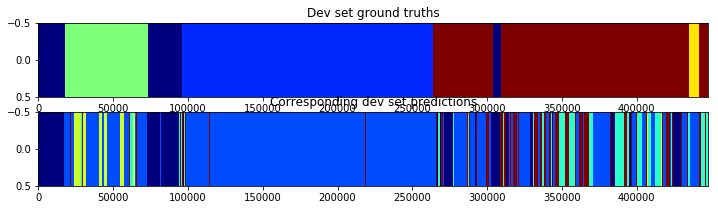

In [46]:
plt.figure(figsize=(12, 3))
Y_dev_lab = np.argmax(Y_dev, axis=-1)
plt.subplot(211)
plt.title('Dev set ground truths')
plt.imshow(Y_dev_lab[iix:iix+1,:].astype(int), aspect='auto', cmap='jet')

plt.subplot(212)
plt.title('Corresponding dev set predictions')
plt.imshow(Y_hat[iix:iix+1,:].astype(int), aspect='auto', cmap='jet')

In [47]:
np.where(np.argmax(Y_hat_p[iix,:,:], axis=-1)==3)

(array([ 24044,  24045,  24047, ..., 446984, 446986, 446987]),)

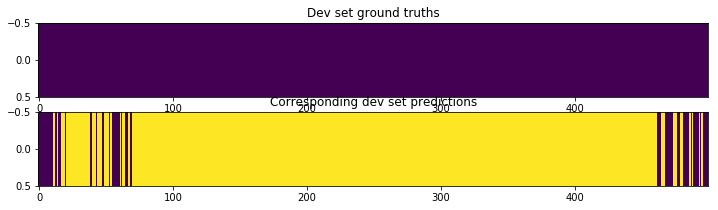

In [48]:
plt.figure(figsize=(12, 3))
Y_dev_lab = np.argmax(Y_dev, axis=-1)
plt.subplot(211)
plt.title('Dev set ground truths')
plt.imshow(Y_dev_lab[iix:iix+1,29000:29500].astype(int), aspect='auto')#, cmap='jet')

plt.subplot(212)
plt.title('Corresponding dev set predictions')
plt.imshow(Y_hat[iix:iix+1,29000:29500].astype(int), aspect='auto')#, cmap='jet')

In [49]:
Y_hat_p[iix,np.where(np.argmax(Y_hat_p[iix,:,:], axis=-1)==3),:]

array([[[1.3591215e-05, 4.0866837e-01, 6.2552929e-02, ...,
         1.1329549e-02, 9.1304451e-02, 6.2038028e-03],
        [1.1851218e-05, 4.1143468e-01, 6.0977980e-02, ...,
         1.0789870e-02, 8.9989357e-02, 5.8751721e-03],
        [1.2946446e-05, 4.1000783e-01, 6.1942454e-02, ...,
         1.1128320e-02, 9.0828143e-02, 6.0830167e-03],
        ...,
        [7.4131164e-04, 1.5416354e-01, 2.5724155e-01, ...,
         4.2861033e-02, 1.7445563e-01, 6.5354601e-02],
        [8.8631868e-04, 1.4161213e-01, 2.7502120e-01, ...,
         4.2397697e-02, 1.8497954e-01, 7.2648861e-02],
        [6.8422954e-04, 1.5977657e-01, 2.6060021e-01, ...,
         4.3445479e-02, 1.8305121e-01, 7.0738174e-02]]], dtype=float32)

In [50]:
# seems like a crf-smoother (even a post-hoc one) could really help
## todo: check out tf2crf